In [1]:
import numpy as np
import pandas as pd


In [2]:
data = pd.read_csv("Tweets.csv")

In [3]:
#get ride of the data that does not contain a reason 

In [4]:
filtered_data = data[data['negativereason'].notnull()]
print len(filtered_data)

9178


In [5]:
#machine learning alg to perdict the reasons 
data_x = filtered_data['text'].tolist( )
data_y = filtered_data['negativereason'].tolist()

data_x = [line.decode('utf-8').strip() for line in data_x]


In [6]:
#stemming and remove stopping words
# -*- coding: utf-8 -*-

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
def preprocess(document):
    processed = []
    tokenizer = RegexpTokenizer(r'\w+')
    intermediate = tokenizer.tokenize(document)
    stop = stopwords.words('english')
    intermediate = [i for i in intermediate if i not in stop]
    # FIXME: using other stemmers also to know quality of each stemmed text
    stemmer = SnowballStemmer("english")
    intermediate = [stemmer.stem(i) for i in intermediate]
    processed.append(intermediate)
    return processed

In [7]:
def group_by_class(data_x,data_y):
    group_data = {}
    for x,y in zip(data_x,data_y):
        group_data.setdefault(y, []).append(preprocess(x))
    return group_data

In [8]:
from collections import Counter
import operator

group_data = group_by_class(data_x,data_y)

word_app = {}
for key,item in group_data.items():
    word_app.setdefault(key,[])
    big_list = []
    for sen in item:
        big_list += sen
    word_freq = Counter(big_list)
    sorted_word_freq = sorted(word_freq.items(), key=operator.itemgetter(1))

    word_app[key] = Counter(big_list)







print len(word_app)



TypeError: unhashable type: 'list'

ValueError: too many values to unpack

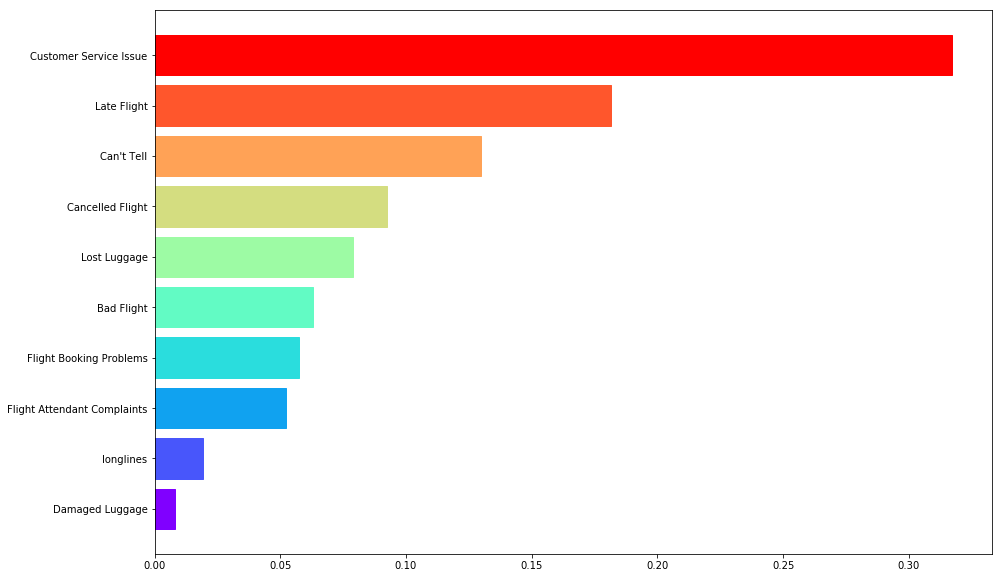

In [9]:
# groupby reason and count 
groupby_reason = filtered_data.groupby('negativereason').agg('count')

hist_freq = groupby_reason['tweet_id'].tolist()
hist_freq_per = [i*1./sum(hist_freq) for i in hist_freq]

reason_name = groupby_reason.index
reason_name = reason_name[sorted(range(len(hist_freq_per)),key = lambda k:hist_freq_per[k] )]
hist_freq_per.sort()
y_pos = np.arange(len(reason_name))
#creat the bar plot
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 

import numpy as np 
color=cm.rainbow(np.linspace(0,1,len(reason_name)))

%matplotlib inline 
plt.figure(figsize = (15,10))
barlist = plt.barh(y_pos,hist_freq_per)
plt.yticks(y_pos,reason_name)
for i in range(len(reason_name)):
    barlist[i].set_color(color[i])
font = {'weight' : 'bold',
        'size'   : 80}
plt.ylim((0,0.5,20))

plt.rc('font', **font)
#change bar color 

plt.show()



In [10]:
#machine learning alg to perdict the reasons 
data_x = filtered_data['text'].tolist( )
data_y = filtered_data['negativereason'].tolist()


#SVM with tf-idf

#train_test_split


from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1, random_state=8)
text_clf_svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])

text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
print np.mean(predicted_svm == y_test)


#




0.578431372549


In [11]:
# Stemming Code
# stemming - svm 

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=22))])

text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)

predicted_mnb_stemmed = text_mnb_stemmed.predict(X_test)

wrong_pred = {}
for i in range(len(X_test)):
    if predicted_mnb_stemmed[i] != y_test[i]:
        wrong_pred.setdefault(y_test[i], []).append(X_test[i])
print wrong_pred
from collections import Counter
        
hist =  Counter(y_test)
class_name = []
acc_by_class = []
for key,items in wrong_pred.items():
    class_name.append(key)
    acc_by_class.append(1-len(items)*1./hist[key])

print class_name 
print acc_by_class

np.mean(predicted_mnb_stemmed == y_test)

{'Flight Attendant Complaints': ['@USAirways flight 850. RUDE RUDE RUDE service! Awful.', '@VirginAmerica husband and I ordered three drinks via my screen and they never came. Awesome!', "@AmericanAir you have the poorest trained employees at these desks. I haven't even started to discuss the #lostluggage yet", "@AmericanAir @yvonneokaka When do I get my personal response and apology for your crew's having forgotten to load baggage onto my flight?", '@united not for me.  I am on another Ua flight 2 gates down that was held 15 mins for cnx pax.', '@united I mean, your employees were really nice as I literally sobbed?', '@AmericanAir a worker just checked for ice on our plane using his cell phone flashlight! Really?! Come on!', '@USAirways with such disrespect I cannot even begin to explain. He has an issue with women and he literally yelled at me and pulled me off', '@JetBlue had a potentially stressful situation in reFlight Booking Problems a flight which she diffused and helped make a

0.59694989106753815

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  


Normalized confusion matrix
[[ 0.42  0.17  0.17  0.08  0.    0.08  0.    0.08  0.    0.  ]
 [ 0.09  0.58  0.02  0.22  0.    0.    0.02  0.04  0.02  0.  ]
 [ 0.02  0.04  0.79  0.09  0.    0.    0.    0.04  0.04  0.  ]
 [ 0.03  0.12  0.06  0.49  0.01  0.06  0.07  0.09  0.05  0.01]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [ 0.08  0.08  0.    0.31  0.    0.54  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.29  0.    0.    0.57  0.    0.14  0.  ]
 [ 0.08  0.1   0.04  0.08  0.    0.05  0.01  0.54  0.05  0.04]
 [ 0.04  0.    0.04  0.    0.    0.    0.    0.04  0.88  0.  ]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]]


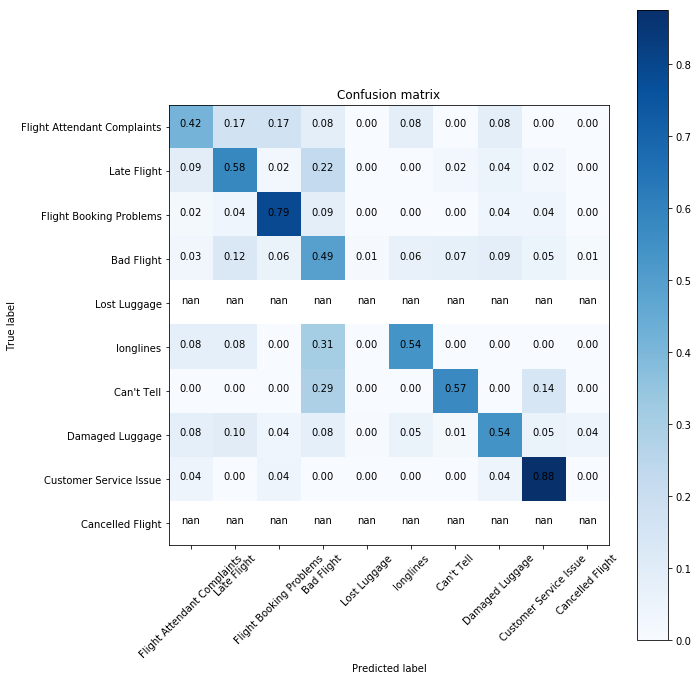

In [17]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize = 10)
    plt.yticks(tick_marks, classes,fontsize = 10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = confusion_matrix(predicted_mnb_stemmed, y_test)
np.set_printoptions(precision=2)
classname = set(y_test)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_name,normalize=True,
                      title='Confusion matrix')

In [13]:
# stemming - bayes
from nltk.stem.snowball import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB

stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('mnb', MultinomialNB(fit_prior=False))])

text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)

predicted_mnb_stemmed = text_mnb_stemmed.predict(X_test)







np.mean(predicted_mnb_stemmed == y_test)


0.53703703703703709

In [14]:
#prepare data for the attention model 
data_x = filtered_data['text'].tolist( )
data_y = filtered_data['negativereason'].tolist()
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(data_y)
num_data_y = le.transform(data_y)
label_names = list(le.classes_)
num_of_class = len(label_names)
print num_of_class
print label_names






10
['Bad Flight', "Can't Tell", 'Cancelled Flight', 'Customer Service Issue', 'Damaged Luggage', 'Flight Attendant Complaints', 'Flight Booking Problems', 'Late Flight', 'Lost Luggage', 'longlines']


In [22]:
# -*- coding: utf-8 -*-
#training the model.
#process--->1.load data(X:list of lint,y:int). 2.create session. 3.feed data. 4.training (5.validation) ,(6.prediction)
import sys
reload(sys)
sys.setdefaultencoding('utf8')
import tensorflow as tf
import numpy as np
from word_attention.p1_HierarchicalAttention_model import HierarchicalAttention
# from p1_HierarchicalAttention_model_transformer import HierarchicalAttention

# from data_util_zhihu import load_data_multilabel_new,create_voabulary,create_voabulary_label
from tflearn.data_utils import to_categorical, pad_sequences
import os
from word_attention.preprocess import *
# import word2vec
import pickle
from sklearn.model_selection import train_test_split

#configuration
FLAGS=tf.app.flags.FLAGS
tf.app.flags.DEFINE_integer("num_classes",10,"number of label")
tf.app.flags.DEFINE_float("learning_rate",0.01,"learning rate") #TODO 0.01
tf.app.flags.DEFINE_integer("batch_size", 16, "Batch size for training/evaluating.") #批处理的大小 32-->128 #TODO
tf.app.flags.DEFINE_integer("decay_steps", 5000, "how many steps before decay learning rate.") #6000批处理的大小 32-->128
tf.app.flags.DEFINE_float("decay_rate", 0.65, "Rate of decay for learning rate.") #0.87一次衰减多少
tf.app.flags.DEFINE_string("ckpt_dir","text_attention_checkpoint/","checkpoint location for the model")
tf.app.flags.DEFINE_integer("sequence_length",50,"max sentence length")
tf.app.flags.DEFINE_integer("embed_size",100,"embedding size")
tf.app.flags.DEFINE_boolean("is_training",True,"is traning.true:tranining,false:testing/inference")
tf.app.flags.DEFINE_integer("num_epochs",100,"number of epochs to run.")
tf.app.flags.DEFINE_integer("validate_every", 1, "Validate every validate_every epochs.") #每10轮做一次验证
tf.app.flags.DEFINE_integer("validate_step", 1000, "how many step to validate.") #1500做一次检验 TODO
tf.app.flags.DEFINE_boolean("use_embedding",True,"whether to use embedding or not.")
#tf.app.flags.DEFINE_string("cache_path","text_cnn_checkpoint/data_cache.pik","checkpoint location for the model")
#train-zhihu4-only-title-all.txt
tf.app.flags.DEFINE_string("traning_data_path","train-zhihu4-only-title-all.txt","path of traning data.") #O.K.train-zhihu4-only-title-all.txt-->training-data/test-zhihu4-only-title.txt--->'training-data/train-zhihu5-only-title-multilabel.txt'
tf.app.flags.DEFINE_string("word2vec_model_path","zhihu-word2vec-title-desc.bin-100","word2vec's vocabulary and vectors") #zhihu-word2vec.bin-100-->zhihu-word2vec-multilabel-minicount15.bin-100
tf.app.flags.DEFINE_boolean("multi_label_flag",False,"use multi label or single label.")
tf.app.flags.DEFINE_integer("num_sentences", 1, "number of sentences in the document") #每10轮做一次验证
tf.app.flags.DEFINE_integer("hidden_size",100,"hidden size")
tf.app.flags.DEFINE_boolean("early_stopping",True,"whether to enforce early stopping.")
tf.app.flags.DEFINE_string("save_file_name",'train_hist.p','output hsitory file name')

#1.load data(X:list of lint,y:int). 2.create session. 3.feed data. 4.training (5.validation) ,(6.prediction)
def main(_):
    #1.load data(X:list of lint,y:int).
    #if os.path.exists(FLAGS.cache_path):  # 如果文件系统中存在，那么加载故事（词汇表索引化的）
    #    with open(FLAGS.cache_path, 'r') as data_f:
    #        trainX, trainY, testX, testY, vocabulary_index2word=pickle.load(data_f)
    #        vocab_size=len(vocabulary_index2word)
    #else:
    if 1==1:
        # trainX, trainY, testX, testY = None, None, None, None
        # vocabulary_word2index, vocabulary_index2word = create_voabulary(word2vec_model_path=FLAGS.word2vec_model_path,name_scope="hierAtten") #simple='simple'
        # vocab_size = len(vocabulary_word2index)
        # print("cnn_model.vocab_size:",vocab_size)
        # vocabulary_word2index_label,vocabulary_index2word_label = create_voabulary_label(name_scope="hierAtten")
        # if FLAGS.multi_label_flag:
        #     FLAGS.traning_data_path='training-data/train-zhihu6-title-desc.txt' #test-zhihu5-only-title-multilabel.txt
        # train, test, _ = load_data_multilabel_new(vocabulary_word2index, vocabulary_word2index_label,multi_label_flag=FLAGS.multi_label_flag,traning_data_path=FLAGS.traning_data_path) #,traning_data_path=FLAGS.traning_data_path
        # trainX, trainY = train
        # testX, testY = test
#         all_sentences,labels,label_names = load_data('../modified_text/')
        all_sentences = data_x
        labels = num_data_y
        label_names = ['Bad Flight', "Can't Tell", 'Cancelled Flight', 'Customer Service Issue', 'Damaged Luggage', 'Flight Attendant Complaints', 'Flight Booking Problems', 'Late Flight', 'Lost Luggage', 'longlines']

        wordVocab, embedding_array = load_pretraind_embedding_glove("./glove.6B.50d.txt")
        data_X = text_to_index(all_sentences,'train_id_mat.npy',wordVocab,FLAGS.sequence_length)
        data_Y = labels
        trainX, testX, trainY, testY = train_test_split(data_X, data_Y, test_size=0.1, random_state=42)
        vocab_size  = len(wordVocab) #no use


        # 2.Data preprocessing.Sequence padding
        print("start padding & transform to one hot...")
        print("trainX[0]:", trainX[0]) 
        print len(trainX) 
        # trainX = pad_sequences(trainX, maxlen=FLAGS.sequence_length, value=0.)  # padding to max length
        # testX = pad_sequences(testX, maxlen=FLAGS.sequence_length, value=0.)  # padding to max length
        #with open(FLAGS.cache_path, 'w') as data_f: #save data to cache file, so we can use it next time quickly.
        #    pickle.dump((trainX,trainY,testX,testY,vocabulary_index2word),data_f)
        print("trainX[0]:", trainX[0]) #;print("trainY[0]:", trainY[0])
        # Converting labels to binary vectors
        # print("end padding & transform to one hot...")
    #2.create session.
    train_loss_hist,train_acc_hist,test_loss_hist,test_acc_hist = [],[],[],[]

    config=tf.ConfigProto()
    config.gpu_options.allow_growth=True
    with tf.Session(config=config) as sess:
        #Instantiate Model
        #num_classes, learning_rate, batch_size, decay_steps, decay_rate,sequence_length,num_sentences,vocab_size,embed_size,
        #hidden_size,is_training
        model=HierarchicalAttention(FLAGS.num_classes, FLAGS.learning_rate, FLAGS.batch_size, FLAGS.decay_steps, FLAGS.decay_rate,FLAGS.sequence_length,
                                       FLAGS.num_sentences,vocab_size,FLAGS.embed_size,FLAGS.hidden_size,FLAGS.is_training,multi_label_flag=FLAGS.multi_label_flag)
        #Initialize Save
        saver=tf.train.Saver()
        if os.path.exists(FLAGS.ckpt_dir+"checkpoint"):
            print("Restoring Variables from Checkpoint")
            saver.restore(sess,tf.train.latest_checkpoint(FLAGS.ckpt_dir))
        else:
            print('Initializing Variables')
            sess.run(tf.global_variables_initializer())
            if FLAGS.use_embedding: #load pre-trained word embedding
                # assign_pretrained_word_embedding(sess, vocabulary_index2word, vocab_size, model,word2vec_model_path=FLAGS.word2vec_model_path)
                _,word_Embedding = load_pretrained_embedding("../material_embedding/word2vec_embeddings-SNAPSHOT.model")
                t_assign_embedding = tf.assign(model.Embedding,word_Embedding)  # assign this value to our embedding variables of our model.
                sess.run(t_assign_embedding)
        curr_epoch=sess.run(model.epoch_step)
        #3.feed data & training
        number_of_training_data=len(trainX)
        print("number_of_training_data:",number_of_training_data)
        previous_eval_loss=10000
        best_eval_loss=10000
        batch_size=FLAGS.batch_size
        for epoch in range(curr_epoch,FLAGS.num_epochs):
            loss, acc, counter = 0.0, 0.0, 0
            for start, end in zip(range(0, number_of_training_data, batch_size),range(batch_size, number_of_training_data, batch_size)):
                if epoch==0 and counter==0:
                    print("trainX[start:end]:",trainX[start:end])#;print("trainY[start:end]:",trainY[start:end])
                feed_dict = {model.input_x: trainX[start:end],model.dropout_keep_prob: 0.5}
                if not FLAGS.multi_label_flag:
                    feed_dict[model.input_y] = trainY[start:end]
                else:
                    feed_dict[model.input_y_multilabel]=trainY[start:end]
                curr_loss,curr_acc,_=sess.run([model.loss_val,model.accuracy,model.train_op],feed_dict) #curr_acc--->TextCNN.accuracy
                loss,counter,acc=loss+curr_loss,counter+1,acc+curr_acc
                if counter %1==0:
                    print("HierAtten_0609drate0.75==>Epoch %d\tBatch %d\tTrain Loss:%.3f\tTrain Accuracy:%.3f" %(epoch,counter,loss/float(counter),acc/float(counter))) #tTrain Accuracy:%.3f---》acc/float(counter)
                    train_loss_hist.append(loss/float(counter)) 
                    train_acc_hist.append(acc/float(counter))
                ##VALIDATION VALIDATION VALIDATION PART######################################################################################################
                if FLAGS.batch_size!=0 and (start%(FLAGS.validate_step*FLAGS.batch_size)==0): #(epoch % FLAGS.validate_every) or  if epoch % FLAGS.validate_every == 0:
                    eval_loss, eval_acc = do_eval(sess, model, testX, testY, batch_size)
                    print("validation.part. previous_eval_loss:", previous_eval_loss,";current_eval_loss:", eval_loss)
                    if eval_loss > previous_eval_loss: #if loss is not decreasing
                        # reduce the learning rate by a factor of 0.5
                        print("HierAtten_0609drate0.75==>validation.part.going to reduce the learning rate.")
                        learning_rate1 = sess.run(model.learning_rate)
                        lrr=sess.run([model.learning_rate_decay_half_op])
                        learning_rate2 = sess.run(model.learning_rate)
                        print("HierAtten_0609drate0.75==>validation.part.learning_rate1:", learning_rate1, " ;learning_rate2:",learning_rate2)
                    #print("HierAtten==>Epoch %d Validation Loss:%.3f\tValidation Accuracy: %.3f" % (epoch, eval_loss, eval_acc))
                    else:# loss is decreasing
                        if eval_loss<best_eval_loss:
                            print("HierAtten_0609drate0.75==>going to save the model.eval_loss:",eval_loss,";best_eval_loss:",best_eval_loss)
                            # save model to checkpoint
                            save_path = FLAGS.ckpt_dir + "model.ckpt"
                            saver.save(sess, save_path, global_step=epoch)
                            best_eval_loss=eval_loss
                    previous_eval_loss = eval_loss
                ##VALIDATION VALIDATION VALIDATION PART######################################################################################################

            #epoch increment
            print("going to increment epoch counter....")
            sess.run(model.epoch_increment)

            # 4.validation
            print(epoch,FLAGS.validate_every,(epoch % FLAGS.validate_every==0))
            if epoch % FLAGS.validate_every==0:
                eval_loss, eval_acc=do_eval(sess,model,testX,testY,batch_size)
                test_loss_hist.append(eval_loss)
                test_acc_hist.append(eval_acc)
                print("HierAtten==>Epoch %d Validation Loss:%.3f\tValidation Accuracy: %.3f" % (epoch,eval_loss,eval_acc))
                #save model to checkpoint
                save_path=FLAGS.ckpt_dir+"model.ckpt"
                saver.save(sess,save_path,global_step=epoch)
                
            #early stopping by training acc
            if FLAGS.early_stopping:
                patience = 8
                min_delta = 0.002
                if not test_acc_hist or len(test_acc_hist) <2:
                    patience_cnt = 0
                else:
                    if test_acc_hist[-1] - test_acc_hist[-2] > min_delta:
                        patience_cnt = 0
                    else:
                        patience_cnt += 1 
                if patience_cnt >= patience:
                    print (train_loss_hist)
                    print("early stopping...")
                    train_hist = [train_loss_hist,train_acc_hist,test_loss_hist,test_acc_hist]
                    save_file_name = FLAGS.save_file_name
                    print save_file_name
                    pickle.dump(train_hist,open(save_file_name,'wb'))
                    break

        # 5.最后在测试集上做测试，并报告测试准确率 Test
        test_loss, test_acc = do_eval(sess, model, testX, testY, batch_size)
        train_hist = [train_loss_hist,train_acc_hist,test_loss_hist,test_acc_hist]
        save_file_name = FLAGS.save_file_name
        pickle.dump(train_hist,open(save_file_name,'wb'))
    pass

# def assign_pretrained_word_embedding(sess,vocabulary_index2word,vocab_size,model,word2vec_model_path=None):
#     print("using pre-trained word emebedding.started.word2vec_model_path:",word2vec_model_path)
#     # word2vecc=word2vec.load('word_embedding.txt') #load vocab-vector fiel.word2vecc['w91874']
#     word2vec_model = word2vec.load(word2vec_model_path, kind='bin')
#     word2vec_dict = {}
#     for word, vector in zip(word2vec_model.vocab, word2vec_model.vectors):
#         word2vec_dict[word] = vector
#     word_embedding_2dlist = [[]] * vocab_size  # create an empty word_embedding list.
#     word_embedding_2dlist[0] = np.zeros(FLAGS.embed_size)  # assign empty for first word:'PAD'
#     bound = np.sqrt(6.0) / np.sqrt(vocab_size)  # bound for random variables.
#     count_exist = 0;
#     count_not_exist = 0
#     for i in range(1, vocab_size):  # loop each word
#         word = vocabulary_index2word[i]  # get a word
#         embedding = None
#         try:
#             embedding = word2vec_dict[word]  # try to get vector:it is an array.
#         except Exception:
#             embedding = None
#         if embedding is not None:  # the 'word' exist a embedding
#             word_embedding_2dlist[i] = embedding;
#             count_exist = count_exist + 1  # assign array to this word.
#         else:  # no embedding for this word
#             word_embedding_2dlist[i] = np.random.uniform(-bound, bound, FLAGS.embed_size);
#             count_not_exist = count_not_exist + 1  # init a random value for the word.
#     word_embedding_final = np.array(word_embedding_2dlist)  # covert to 2d array.
#     word_embedding = tf.constant(word_embedding_final, dtype=tf.float32)  # convert to tensor
#     t_assign_embedding = tf.assign(model.Embedding,word_embedding)  # assign this value to our embedding variables of our model.
#     sess.run(t_assign_embedding);
#     print("word. exists embedding:", count_exist, " ;word not exist embedding:", count_not_exist)
#     print("using pre-trained word emebedding.ended...")

# 在验证集上做验证，报告损失、精确度
def do_eval(sess,textCNN,evalX,evalY,batch_size):
    number_examples=len(evalX)
    eval_loss,eval_acc,eval_counter=0.0,0.0,0
    for start,end in zip(range(0,number_examples,batch_size),range(batch_size,number_examples,batch_size)):
        feed_dict = {textCNN.input_x: evalX[start:end], textCNN.dropout_keep_prob: 1}
        if not FLAGS.multi_label_flag:
            feed_dict[textCNN.input_y] = evalY[start:end]
        else:
            feed_dict[textCNN.input_y_multilabel] = evalY[start:end]
        curr_eval_loss, logits,curr_eval_acc= sess.run([textCNN.loss_val,textCNN.logits,textCNN.accuracy],feed_dict)#curr_eval_acc--->textCNN.accuracy
        #label_list_top5 = get_label_using_logits(logits_[0], vocabulary_index2word_label)
        #curr_eval_acc=calculate_accuracy(list(label_list_top5), evalY[start:end][0],eval_counter)
        eval_loss,eval_acc,eval_counter=eval_loss+curr_eval_loss,eval_acc+curr_eval_acc,eval_counter+1
    return eval_loss/float(eval_counter),eval_acc/float(eval_counter)

#从logits中取出前五 get label using logits
def get_label_using_logits(logits,vocabulary_index2word_label,top_number=1):
    #print("get_label_using_logits.logits:",logits) #1-d array: array([-5.69036102, -8.54903221, -5.63954401, ..., -5.83969498,-5.84496021, -6.13911009], dtype=float32))
    index_list=np.argsort(logits)[-top_number:]
    index_list=index_list[::-1]
    #label_list=[]
    #for index in index_list:
    #    label=vocabulary_index2word_label[index]
    #    label_list.append(label) #('get_label_using_logits.label_list:', [u'-3423450385060590478', u'2838091149470021485', u'-3174907002942471215', u'-1812694399780494968', u'6815248286057533876'])
    return index_list

#统计预测的准确率
def calculate_accuracy(labels_predicted, labels,eval_counter):
    label_nozero=[]
    #print("labels:",labels)
    labels=list(labels)
    for index,label in enumerate(labels):
        if label>0:
            label_nozero.append(index)
    if eval_counter<2:
        print("labels_predicted:",labels_predicted," ;labels_nozero:",label_nozero)
    count = 0
    label_dict = {x: x for x in label_nozero}
    for label_predict in labels_predicted:
        flag = label_dict.get(label_predict, None)
    if flag is not None:
        count = count + 1
    return count / len(label_nozero)

if __name__ == "__main__":
    tf.app.run()


ArgumentError: argument --num_classes: conflicting option string(s): --num_classes

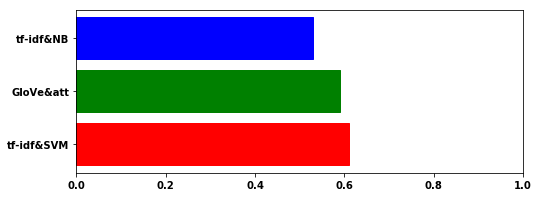

In [70]:
#creat the bar plot
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 
x_name = ['tf-idf&SVM','GloVe&att','tf-idf&NB',]
acc = [0.61,0.59,0.53]
import numpy as np 
color=['r','g','b']
y_pos = np.arange(len(x_name))

%matplotlib inline 
plt.figure(figsize = (8,3))
# barlist = plt.barh(y_pos,x_name)
barlist = plt.barh(y_pos,acc)

plt.yticks(y_pos,x_name)
for i in range(len(x_name)):
    barlist[i].set_color(color[i])
font = {'weight' : 'bold',
        'size'   : 20}
plt.xlim(0,1)

plt.rc('font', **font)
#change bar color 

plt.show()

